## Part1  Exploratory Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report,ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
# load the dataest 
# The data is available as a JSON file: 'logins.json'

df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#Get a summary of the dataset
df.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
#Get the type of data for each column of the dataset
df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
#Create groups based on login_time with interval of 15 mins
df_groups = df.groupby(pd.Grouper(key='login_time', freq='15min'))
df_groups.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
...,...
93134,1970-04-13 18:46:06
93136,1970-04-13 18:48:52
93137,1970-04-13 18:50:19
93139,1970-04-13 18:54:02


In [6]:
#Convert from pandas group object to a list of groups
groups = list(df_groups)
groups[0]

(Timestamp('1970-01-01 20:00:00', freq='15T'),
            login_time
 6 1970-01-01 20:12:16
 0 1970-01-01 20:13:18)

In [7]:
type(groups[0])

tuple

In [8]:
#generate a dictionary which has the time_interval as key and login_times as values
logins_counts = {}
for i in range(len(groups)):
    count = len(groups[i][1])
    logins_counts[str(groups[i][0])] = count

In [9]:
logins_counts

{'1970-01-01 20:00:00': 2,
 '1970-01-01 20:15:00': 6,
 '1970-01-01 20:30:00': 9,
 '1970-01-01 20:45:00': 7,
 '1970-01-01 21:00:00': 1,
 '1970-01-01 21:15:00': 4,
 '1970-01-01 21:30:00': 0,
 '1970-01-01 21:45:00': 4,
 '1970-01-01 22:00:00': 9,
 '1970-01-01 22:15:00': 8,
 '1970-01-01 22:30:00': 1,
 '1970-01-01 22:45:00': 3,
 '1970-01-01 23:00:00': 16,
 '1970-01-01 23:15:00': 13,
 '1970-01-01 23:30:00': 14,
 '1970-01-01 23:45:00': 15,
 '1970-01-02 00:00:00': 10,
 '1970-01-02 00:15:00': 18,
 '1970-01-02 00:30:00': 12,
 '1970-01-02 00:45:00': 13,
 '1970-01-02 01:00:00': 9,
 '1970-01-02 01:15:00': 8,
 '1970-01-02 01:30:00': 10,
 '1970-01-02 01:45:00': 6,
 '1970-01-02 02:00:00': 7,
 '1970-01-02 02:15:00': 18,
 '1970-01-02 02:30:00': 12,
 '1970-01-02 02:45:00': 6,
 '1970-01-02 03:00:00': 12,
 '1970-01-02 03:15:00': 5,
 '1970-01-02 03:30:00': 6,
 '1970-01-02 03:45:00': 5,
 '1970-01-02 04:00:00': 2,
 '1970-01-02 04:15:00': 0,
 '1970-01-02 04:30:00': 5,
 '1970-01-02 04:45:00': 2,
 '1970-01-02 05:

In [10]:
#create a dataframe from the dictionary generated above
df_logins_counts= pd.DataFrame.from_dict(logins_counts, orient='index', columns=['login_counts'])

In [11]:
df_logins_counts.index = pd.to_datetime(df_logins_counts.index)

In [12]:
df_logins_counts.head()

,login_counts
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


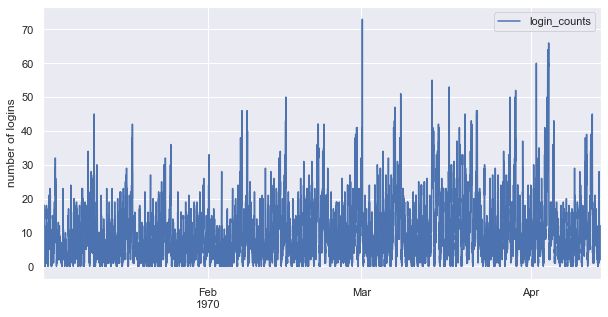

In [13]:
#
df_logins_counts.plot(figsize=(10,5))
plt.ylabel('number of logins')
plt.show();

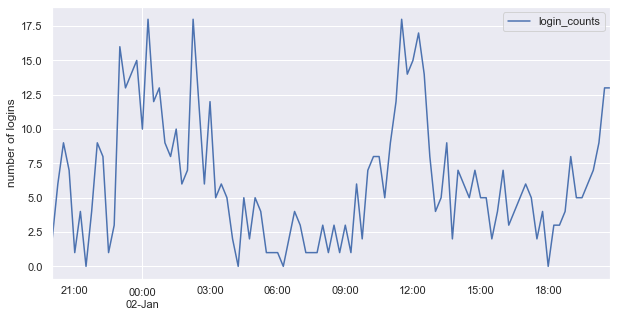

In [14]:
#Zoom in to see # logins in an invidual day
df_logins_counts[:100].plot(figsize=(10,5))
plt.ylabel('number of logins')
plt.show();

In [15]:
df_logins_counts.describe()

,login_counts
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [16]:
df_logins_counts[df_logins_counts.login_counts == 73].index[0]

Timestamp('1970-03-01 04:30:00')

In [17]:
df_logins_counts[df_logins_counts.login_counts == 73].index[0].dayofweek

6

- In the graph above, it shows that there is a trend of high-peaks alternating with low-peaks present within this dataset. There seems to be corresponding to a high-peak and low-peak time for each day and the interval seems to be 12 hours (middle night and noon).

- The maximum peak (73) is on March 1, Sunday.
- In order to test if Sunday always has the highest peak for each week, we need find the max peak for each week. In order to accomplish this, we will divide the length of the df_logins_counts by 96 (24 hours/day => 1440 minutes per day => 96 data points/day for 15 min interval) and then divide by 7 to get the number of weeks in this dataset.

In [18]:
# Get the number of weeks from the data set
len(df_logins_counts)/96/7

14.56547619047619

In [19]:
max_day_of_week = {}

for i in range(14):
    max_peak = df_logins_counts[i*96*7:(i+1)*96*7].login_counts.max()
    day_of_week = df_logins_counts[df_logins_counts.login_counts == max_peak].index[0].dayofweek
    login_interval = df_logins_counts[df_logins_counts.login_counts == max_peak].index[0]
    max_day_of_week[login_interval] = day_of_week

df_max_day_of_week = pd.DataFrame.from_dict(max_day_of_week, orient='index', columns=['day_of_week'])

df_max_day_of_week.groupby(by='day_of_week').size()

day_of_week
2    1
4    1
5    2
6    8
dtype: int64

It appears that there are 8 weeks that have Sunday as the highest peak within a week, 2 weeks that have Saturday as the highest peak day, 1 week that has Thursday as the high-peak day and 1 week that has Wednesday as the highest-peak day.

Overall, this trend tells us that the weekends are commonly the highest-peak days.

### Experiment and metric design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However a toll bridge , with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


I would choose weekend engagement for drivers in both cities as the key measure of success of this experiment. 
The main reason is that there is a high-peak and low-peak activities during the weekdays (as we have seen in the graph above) during a 12-hour period, it would be less likely that the drivers would want to work for more than 12 hours in order to take the advantage of both cities. However, there is a reasonable activity in both cities during the weekends and thus it is more than likely they will try to drive back and forth between the two cities to get reimbursement of the tolls.


Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

How you will implement the experiment
What statistical test(s) you will conduct to verify the significance of the observation
How you would interpret the results and provide recommendations to the city operations team along with any caveats


- First, I would track the drivers' activity during the weekends in both cities before implementing any changes to the city policy. 

 - After I get the initial dataset of the activities of all drivers in the cities, the new change of the policy would then be announced to drivers that the tolls will be reimbursed if they take the bridge between the two cities.
 
- After that, I will then monitor their activities in both cities during the weekends. For the initial dataset (before an announcement was made), I would make the comparison to determine which city the drivers tend to serve, if there is any, during weekends. This would give me a ratio of the number of trips in one city versus the number of trips in another city. 

- I then do a two-tailed t-test to compare the number of trips back and forth between the two cities during the weekends before and after the policy has been changed. In order to conduct a t-test, I would need to first specify a statistical significance (5%). If the p-value of the two-tailed t-test turns out to be greater than the level of significance, then there is no difference before and after the policy change. However, if the p-value is less than the significance level then I would recommend the policy to be changed permanently.

### Predictive modeling

#### Explore the retention rate of drivers

**Data description**

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekd

In [20]:
import json

with open('ultimate_data_challenge.json') as f:
    ultimate_data = json.load(f)

data = pd.DataFrame(ultimate_data)
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


- The dataset was about the users who signed up in Jan 2014.
- In order to calculate the retention rate, we must know whether the last_trip_date falls within the 30 days of the 6 month period after they signed up. Since we don't know the time that the data was pulled out, I would assume 6 months from the signup date to be the timeframe.

In [23]:
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)

In [24]:
# 'active' in the preceding 30 days
data['6months_from_signup'] = data.signup_date + pd.Timedelta('181D')
data['30days_start'] = data['6months_from_signup'] - pd.Timedelta('30D')
data['active'] = data['last_trip_date'] >= data['30days_start']

In [25]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6months_from_signup,30days_start,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,2014-06-25,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,2014-06-29,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,2014-06-06,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,2014-06-10,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27,2014-06-27,False


In [26]:
retention_rate = 100.0 *len(data[data['active'] == True]) / len(data)
print ('The retention rate is {}%.'.format(retention_rate))

The retention rate is 24.396%.


#### Modeling

Determine whether a user will be active or not in their 6th month on the system

In [27]:
# convert boolean to 0/1
data['ultimate_black_user'] = data['ultimate_black_user'] *1
data['active'] = data['active'] *1

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  6months_from_signup     50000 non-null  dateti

In [29]:
# let's only look at the numeric data portion of the dataset
numeric_data = data._get_numeric_data()
numeric_data.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0


In [30]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    41878 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    49799 non-null  float64
 8   active                  50000 non-null  int32  
dtypes: float64(6), int32(2), int64(1)
memory usage: 3.1 MB


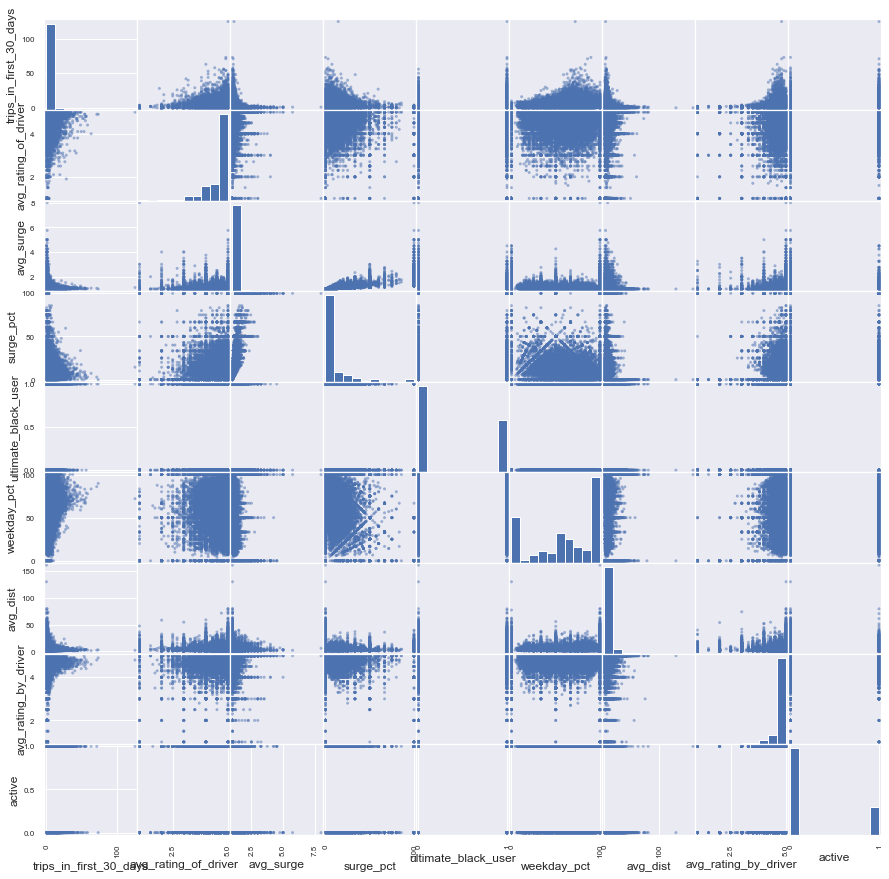

In [31]:
#Let's take a look at the correlation between 2 different variables, including the 'target' variable
from pandas.plotting import scatter_matrix

scatter_matrix(numeric_data, figsize=(15, 15))
plt.show();

- Based in on the matrix plot above, none of the numeric variables is very strongly correlated to another so that we can include all features into our predictive model if necessary.
- We need encode categorical variables using Label Encoder. For example, if the user experience on iphone is very bad in comparison to those using Android then this could absolutely affect the retention rate. 

In [32]:
data = data.dropna()

In [33]:
#transfrom cateogorical columns into numerical columns using sklearn.preprocessing

le = LabelEncoder()
le.fit(data.city.unique())
data.city = le.transform(data.city)

In [34]:
LE = LabelEncoder()
LE.fit(data.phone.unique())
data.phone = LE.transform(data.phone)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  int32         
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  int32         
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  int32         
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  6months_from_signup     41445 non-null  dateti

In [36]:
#recheck retention rate after dropping na to make sure this is the right method to deal with NA values
retention_rate = 100.0 *len(data[data['active'] == True]) / len(data)
print ('The retention rate is {}%.'.format(round(retention_rate,2)))

The retention rate is 27.11%.


The retention rate changes from 24.4% to 27.1%, which is not that significant and thus I decided to drop the NA values and move on with data analysis and model selection process.

#### Train/test split

In [37]:
#Splitting features versus target
X = data.drop(['active', 'last_trip_date', 'signup_date', '30days_start', '6months_from_signup'], axis=1)
y = data.active

Since the problem we are having here is to predict whether an individual driver will stay after 6 months with Ultimate, this is a binary classification problem; I would choose to use logistic regression method first.

In [38]:
#Splitting the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Create a Logistic Regression classifier
lg = LogisticRegression()

#Fit the classifier to the training data
lg.fit(X_train, y_train)

#Predict the labels for the test set:
y_pred = lg.predict(X_test)

#evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('The accuracy score is ', accuracy_score(y_test, y_pred)*100)

[[8759  283]
 [2965  427]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      9042
           1       0.60      0.13      0.21      3392

    accuracy                           0.74     12434
   macro avg       0.67      0.55      0.53     12434
weighted avg       0.71      0.74      0.67     12434

The accuracy score is  73.87807624256072


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#
lg = LogisticRegression()
# Fit the model on the trainng data.
lg.fit(X_train, y_train)

LogisticRegression()

[[8762  280]
 [2961  431]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      9042
           1       0.61      0.13      0.21      3392

    accuracy                           0.74     12434
   macro avg       0.68      0.55      0.53     12434
weighted avg       0.71      0.74      0.67     12434

The accuracy score is  73.93437349203796


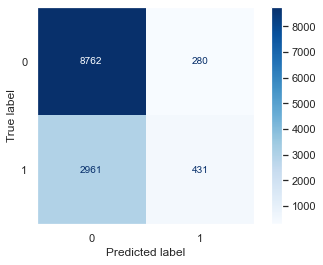

In [40]:
# Print the accuracy from the testing data.
y_pred = lg.predict(X_test)
#evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('The accuracy score is ', accuracy_score(y_test, y_pred)*100)

#plot
cf=confusion_matrix(y_test, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cf).plot(cmap='Blues')
plt.grid(False)
plt.show();

In [41]:
# feature importance 
lg_feature_importance = pd.DataFrame(np.transpose(lg.coef_), index=X.columns, columns=['feature_importance']).reset_index()
lg_feature_importance.columns = ['feature', 'feature_importance']
lg_feature_importance.sort_values('feature_importance', ascending=False)

,feature,feature_importance
4,phone,0.440688
6,ultimate_black_user,0.352883
1,trips_in_first_30_days,0.345593
0,city,0.167220
5,surge_pct,0.162366
2,avg_rating_of_driver,0.018357
7,weekday_pct,-0.008251
9,avg_rating_by_driver,-0.023161
3,avg_surge,-0.116035
8,avg_dist,-0.227237


<AxesSubplot:ylabel='feature'>

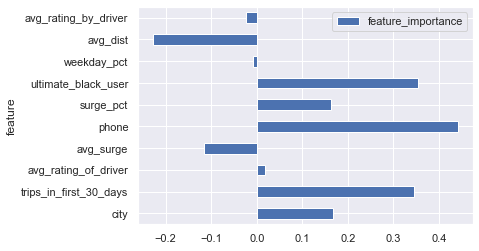

In [42]:
# barplot
lg_feature_importance.plot(kind='barh', x ='feature')

It is very interesting to see the top 5 important features that have a large influence to the logistic regression model:
     - phone
     - ultimate_black_user
     - trip_in_first_30_days
     - city
     - avg_surge. 
     
     This fact implies that we could drop the other features in our process of building the logistic regression model for this kind of problem. The overvall accuracy score for this model is 73.9% with the confusion matrix shown above. We can further tune hyperparameter using a GridSearch as way to cross_validate the model.

In [43]:
#Set up a hyperparameter grid 
c_space = np.logspace(-5,8,5)
param_grid = {'C': c_space}

from sklearn.model_selection import GridSearchCV

lg_cv = GridSearchCV(lg, param_grid, cv=5)
lg_cv.fit(X_train, y_train)

y_cv_pred = lg_cv.predict(X_test)
print ("Tuned logistic regression parameters: {}".format(lg_cv.best_params_))
print ('Best score is {}'.format(lg_cv.best_score_))

Tuned logistic regression parameters: {'C': 0.01778279410038923}
Best score is 0.7447175601204264


In [44]:
#Tuning the hyperparameter helps to increase the accuracy score from 73.9 to 74.5, which is not that much.
# try drop a few features that are not as important from the X features list

X_new = X.drop(['surge_pct', 'avg_rating_of_driver', 'avg_rating_by_driver', 'avg_dist'], axis=1)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [45]:
lg_new = LogisticRegression(C=0.018, random_state=42)
lg_new.fit(X_new_train, y_new_train)
y_new_pred = lg_new.predict(X_new_test)

print ('The new accuracy score after dropping some features is {}'.format(accuracy_score(y_new_pred, y_new_test)))

The new accuracy score after dropping some features is 0.7381373652887244


By dropping some features being used to build the logistic regression model, I was able to obtain a 73.8% accuracy in predicting the labels for the users.

### Conclusion

By analyzing the dataset by Ultimate, I was able to establish a binary logistic regression model which could help predicting whether an individual driver will be inactive in 6 months after their first signup. 

The workflow includes:

 - first look at the correlation between two different numerical variables to determine whether there is high correlation exist.
 - I then encoded categorical variables into numeric variables. 
 - One thing to be noted here is that I calculated the retention rate, percentage of active users, based on the assumption that the data was pulled out 6 months after Jan 2014. However, this assumption could be biased and therefore potentially affecting the prediction of the user status (active or not active). 

A more precise time of when the data was collected would help correctly label the status of the user.

The model helps point out the fact the mobile app on the phone could be very important and could affect the user experience a lot, which indirectly affects the user retention rate. Another important fact that Ultimate can also gain from this model is the importance of city feature. It would be very beneficial to compare the active users among cities and determine if there is any big difference and why.